In [1]:
import scipy.io
import scipy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale

In [2]:
from comsolml import read_data
from comsolml.filter import butter_lowpass_filter
from comsolml.custom_fk import tx_fk_plot, make_fk, make_multiple_fk
from comsolml.custom_ml import make_regression_model, make_autoencoder, do_regression, plot_reg_results
from comsolml.vel_estim import FK_thickness_estimation, make_lamb_curves
from comsolml.noise import make_noise

In [3]:
timesamples = 400
noisedb = -24
dt = 1e-6
numsensors = 12#8
circ = 3455*0.2e-3
encoding_dim = 64

In [4]:
def make_dx(decim):
    dx = circ/numsensors*decim
    return dx

def make_dtheta(decim):
    dtheta = 2*np.pi/numsensors*decim
    return dtheta

def conv_m_to_rad(meters, circumference):
    theta = 2*np.pi*meters/circumference
    return theta

# COMSOL Data

In [5]:
filename_synth_s = Path().joinpath('..', 'data', 'input_synth', 'concat_traces_systematic_f80_145_avg79.mat')
X_s = read_data.read_synth(filename_synth_s, 'concat_traces', 9, 18, geom_spread=False, mat_73=False)
filename_synth_r = Path().joinpath('..', 'data', 'input_synth', 'concat_traces_random_f80_145_avg79.mat')
X_r = read_data.read_synth(filename_synth_r, 'concat_traces', 9, 18, geom_spread=False, mat_73=True)
X = np.concatenate((X_s, X_r))
X.shape

(9383, 8, 401)

In [6]:
# Random scale

In [7]:
labels_s = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels_systematic_f80_145_avg79.csv'))
labels_r = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels_random_f80_145_avg79.csv'))
labels = pd.concat((labels_s, labels_r)).reset_index()

In [8]:
labels.rename(columns={'thickness':'Thickness',
                       'depression':'Depression depth',
                       'pitting':'Pitting depth',
                       'depression_mu':'Depression location',
                       'depression_sigma':'Depression width',
                       'thickness_max':'Thickness maximum',
                       'thickness_min':'Thickness minimum',
                       'thickness_mean':'Thickness mean',
                       'thickness_median':'Thickness median',
                       'thickness_std':'Thickness std'}, inplace=True)

In [9]:
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 401)

In [10]:
X_geom = np.divide(X, time_scaling**3)

In [11]:
X_sample_c = X_geom/X_geom.max()

In [12]:
X_sample_c.shape

(9383, 8, 401)

In [13]:
random_scale = np.expand_dims(np.random.normal(loc=1.0, scale=0.4, size=X_sample_c.shape[:2]), axis=2)

In [14]:
random_scale.min()

-0.8285171882325859

In [15]:
X_randsc_c = np.multiply(X_sample_c, random_scale)

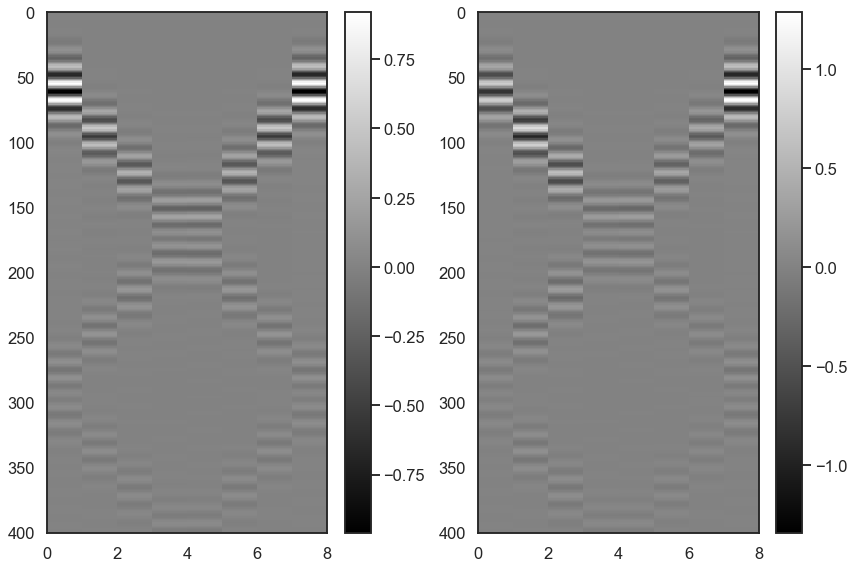

In [16]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pcolormesh(X_sample_c[1,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(122)

plt.pcolormesh(X_randsc_c[1,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()

plt.tight_layout()
plt.show()

In [17]:
X_sample_n = X_randsc_c + make_noise(noisedb, X_randsc_c.shape)

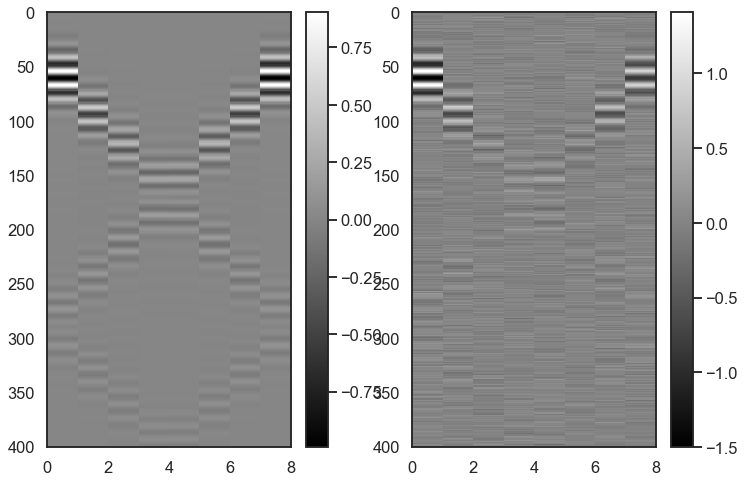

In [18]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pcolormesh(X_sample_c[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(X_sample_n[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

# Conventional Thickness Estimation

In [19]:
steel = make_lamb_curves()


Calculating symmetric modes..

0/100 - 0.0 kHz × mm
1/100 - 101.0 kHz × mm
2/100 - 202.0 kHz × mm
3/100 - 303.0 kHz × mm
4/100 - 404.0 kHz × mm
5/100 - 505.1 kHz × mm
6/100 - 606.1 kHz × mm
7/100 - 707.1 kHz × mm
8/100 - 808.1 kHz × mm
9/100 - 909.1 kHz × mm
10/100 - 1010.1 kHz × mm
11/100 - 1111.1 kHz × mm
12/100 - 1212.1 kHz × mm
13/100 - 1313.1 kHz × mm
14/100 - 1414.1 kHz × mm
15/100 - 1515.2 kHz × mm
16/100 - 1616.2 kHz × mm
17/100 - 1717.2 kHz × mm


c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:227: RuntimeWarning: invalid value encountered in double_scalars
  k = omega/vp
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:229: RuntimeWarning: invalid value encountered in sqrt
  p = np.sqrt((omega/self.c_L)**2 - k**2, dtype=np.complex128)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:230: RuntimeWarning: invalid value encountered in sqrt
  q = np.sqrt((omega/self.c_S)**2 - k**2, dtype=np.complex128)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:256: RuntimeWarning: invalid value encountered in cdouble_scalars
  symmetric = (np.tan(q*self.h)/q
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:257: RuntimeWarning: invalid value encountered in cdouble_scalars
  + (4*(k**2)*p*np.tan(p*self.h))/(q**2 - k**2)**2)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.p

18/100 - 1818.2 kHz × mm
19/100 - 1919.2 kHz × mm
20/100 - 2020.2 kHz × mm
21/100 - 2121.2 kHz × mm
22/100 - 2222.2 kHz × mm
23/100 - 2323.2 kHz × mm
24/100 - 2424.2 kHz × mm
25/100 - 2525.3 kHz × mm
26/100 - 2626.3 kHz × mm
27/100 - 2727.3 kHz × mm
28/100 - 2828.3 kHz × mm
29/100 - 2929.3 kHz × mm
30/100 - 3030.3 kHz × mm
31/100 - 3131.3 kHz × mm
32/100 - 3232.3 kHz × mm
33/100 - 3333.3 kHz × mm
34/100 - 3434.3 kHz × mm
35/100 - 3535.4 kHz × mm
36/100 - 3636.4 kHz × mm
37/100 - 3737.4 kHz × mm
38/100 - 3838.4 kHz × mm
39/100 - 3939.4 kHz × mm
40/100 - 4040.4 kHz × mm
41/100 - 4141.4 kHz × mm
42/100 - 4242.4 kHz × mm
43/100 - 4343.4 kHz × mm
44/100 - 4444.4 kHz × mm
45/100 - 4545.5 kHz × mm
46/100 - 4646.5 kHz × mm
47/100 - 4747.5 kHz × mm
48/100 - 4848.5 kHz × mm
49/100 - 4949.5 kHz × mm
50/100 - 5050.5 kHz × mm
51/100 - 5151.5 kHz × mm
52/100 - 5252.5 kHz × mm
53/100 - 5353.5 kHz × mm
54/100 - 5454.5 kHz × mm
55/100 - 5555.6 kHz × mm
56/100 - 5656.6 kHz × mm
57/100 - 5757.6 kHz × mm


c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:284: RuntimeWarning: invalid value encountered in cdouble_scalars
  + (((q**2 - k**2)**2)*np.tan(p*self.h))/(4*(k**2)*p))
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:283: RuntimeWarning: invalid value encountered in cdouble_scalars
  antisymmetric = (q * np.tan(q*self.h)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:284: RuntimeWarning: invalid value encountered in multiply
  + (((q**2 - k**2)**2)*np.tan(p*self.h))/(4*(k**2)*p))


17/100 - 1717.2 kHz × mm
18/100 - 1818.2 kHz × mm
19/100 - 1919.2 kHz × mm
20/100 - 2020.2 kHz × mm
21/100 - 2121.2 kHz × mm
22/100 - 2222.2 kHz × mm
23/100 - 2323.2 kHz × mm
24/100 - 2424.2 kHz × mm
25/100 - 2525.3 kHz × mm
26/100 - 2626.3 kHz × mm
27/100 - 2727.3 kHz × mm
28/100 - 2828.3 kHz × mm
29/100 - 2929.3 kHz × mm
30/100 - 3030.3 kHz × mm
31/100 - 3131.3 kHz × mm
32/100 - 3232.3 kHz × mm
33/100 - 3333.3 kHz × mm
34/100 - 3434.3 kHz × mm
35/100 - 3535.4 kHz × mm
36/100 - 3636.4 kHz × mm
37/100 - 3737.4 kHz × mm
38/100 - 3838.4 kHz × mm
39/100 - 3939.4 kHz × mm
40/100 - 4040.4 kHz × mm
41/100 - 4141.4 kHz × mm
42/100 - 4242.4 kHz × mm
43/100 - 4343.4 kHz × mm
44/100 - 4444.4 kHz × mm
45/100 - 4545.5 kHz × mm
46/100 - 4646.5 kHz × mm
47/100 - 4747.5 kHz × mm
48/100 - 4848.5 kHz × mm
49/100 - 4949.5 kHz × mm
50/100 - 5050.5 kHz × mm
51/100 - 5151.5 kHz × mm
52/100 - 5252.5 kHz × mm
53/100 - 5353.5 kHz × mm
54/100 - 5454.5 kHz × mm
55/100 - 5555.6 kHz × mm
56/100 - 5656.6 kHz × mm


In [20]:
ds = np.arange(2.4, 10.1, 0.2)
len(ds)

39

In [21]:
ds

array([ 2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,
        4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,
        6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,
        9. ,  9.2,  9.4,  9.6,  9.8, 10. ])

In [111]:
sns.set_context('paper')

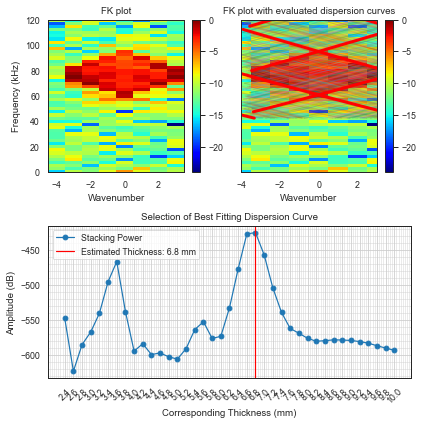

6.8

In [137]:
fk, k_array, f_array = make_fk(X_sample_n[42,:,:].T, dt, make_dtheta(1))
fk = 10*np.log10(np.abs(fk)/np.max(np.abs(fk)))
FK_thickness_estimation(fk, k_array, f_array, make_dtheta(1), steel.vp_antisym['A0'], ds, 40e3, 120e3, angular=True, circumference=circ, db=True, db_down=-24)

In [23]:
labels

,index,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,model_rough_coeff,num_pits
0,0,model_s101_t032_d000_p000,6.4,101,0.0,0.0,351.267366,55.653407,6.4,6.4,6.400000,6.4,0.000000,0.000000,1.000000,0
1,1,model_s101_t032_d000_p002,6.4,101,0.0,0.4,351.267366,55.653407,6.4,6.0,6.209375,6.2,0.145174,0.021076,1.269029,0
2,2,model_s101_t032_d000_p004,6.4,101,0.0,0.8,351.267366,55.653407,6.4,5.6,6.087269,6.2,0.230522,0.053140,1.307393,191
3,3,model_s101_t032_d000_p006,6.4,101,0.0,1.2,351.267366,55.653407,6.4,5.2,6.027662,6.0,0.291548,0.085000,1.317464,78
4,4,model_s101_t032_d000_p008,6.4,101,0.0,1.6,351.267366,55.653407,6.4,4.8,6.005903,6.0,0.324993,0.105621,1.319622,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9378,6037,model_c3456_t050_d023_p009_r998_s1701898195,10.0,1701898195,4.6,1.8,419.313938,23.777331,10.0,5.4,9.559664,10.0,1.084208,1.175507,1.026493,10
9379,6038,model_c3456_t050_d023_p010_r809_s1561625081,10.0,1561625081,4.6,2.0,215.409010,29.107722,10.0,4.8,9.436806,10.0,1.177173,1.385736,1.156334,3
9380,6039,model_c3456_t050_d023_p013_r839_s1610765892,10.0,1610765892,4.6,2.6,184.917121,70.649192,10.0,4.0,8.729167,9.6,1.640418,2.690970,1.145304,5
9381,6040,model_c3456_t050_d024_p003_r960_s1545540344,10.0,1545540344,4.8,0.6,333.771042,83.929996,10.0,4.8,8.528472,9.4,1.691432,2.860943,1.049634,6


In [24]:
X_fk, k_array, f_array = make_multiple_fk(X_sample_n, dt, dx=make_dtheta(1))

In [25]:
X_fk.shape

(9383, 8, 49)

In [26]:
f_array.min(), f_array.max()

(0.0, 119700.7481296758)

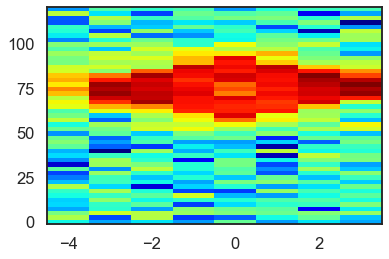

In [27]:
plt.figure()
plt.pcolormesh(k_array, f_array/1e3, X_fk[0,:,:].T, cmap='jet')
plt.show()

In [28]:
len(ds)

39

In [114]:
SPC_recompute = False
SPC_filename = Path().joinpath('..', 'data', 'intermediate', 'SPC_db_sysrand_bound_02_randsc.npy')

In [115]:
if SPC_recompute:
    d_estim = []
    SPC = np.zeros(shape=(len(X_fk), len(ds)))
    for i in range(len(X_fk)):
        d_estim_temp, SPC_temp = FK_thickness_estimation(X_fk[i,:,:].T, k_array, f_array, make_dtheta(1), steel.vp_antisym['A0'], ds, 40e3, 120e3, angular=True, circumference=circ, db=True, plot=False, return_power_curve=True)
        SPC[i,:] = np.array(list(SPC_temp.values()))
        d_estim.append(d_estim_temp)
    np.save(SPC_filename, SPC)
else:
    SPC = np.load(SPC_filename)

In [116]:
FK_thickness_estimation(X_fk[0,:,:].T, k_array, f_array, make_dtheta(1), steel.vp_antisym['A0'], ds, 40e3, 120e3, angular=True, circumference=circ, db=True, plot=True, return_power_curve=False)

ValueError: x dimension of z must have same number of elements as x

In [32]:
len(labels['Thickness mean'])

9383

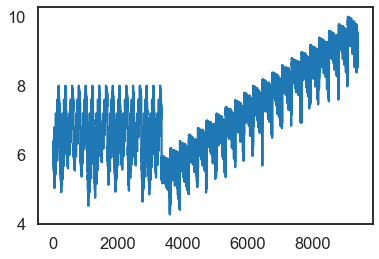

In [33]:
plt.figure()
#plt.plot(d_estim)
plt.plot(labels['Thickness mean'])
plt.show()

In [34]:
SPC.shape

(9383, 39)

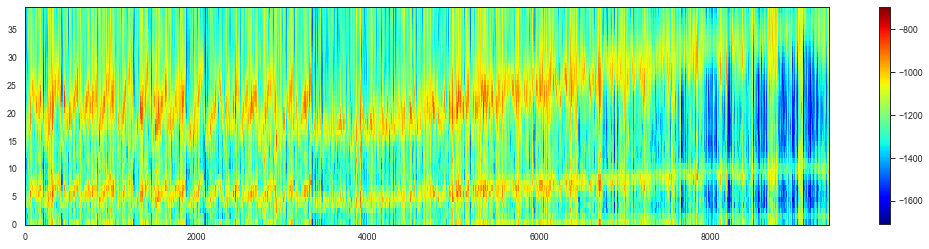

In [118]:
plt.figure(figsize=(18, 4))
plt.pcolormesh(SPC.T, cmap='jet')
#plt.pcolormesh((SPC.T-SPC.min())/(SPC-SPC.min()).max(), cmap='jet')
plt.colorbar()
plt.show()

In [36]:
SPC_norm = (SPC-SPC.min())/((SPC-SPC.min()).max())

In [37]:
attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression width','Pitting depth']

Thickness mean
Layer added; size: 9
Layer added; size: 4
Layer added; size: 2


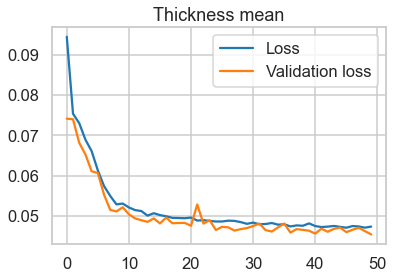

59/59 [==============================] - 0s 1ms/step - loss: 0.0454
loss: 0.04538564383983612
Thickness minimum
Layer added; size: 9
Layer added; size: 4
Layer added; size: 2


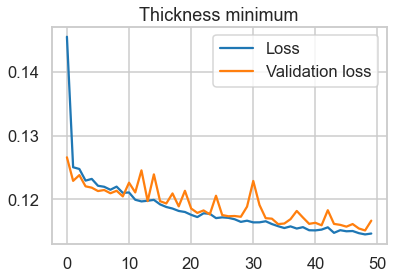

59/59 [==============================] - 0s 1ms/step - loss: 0.1166
loss: 0.11664609611034393
Thickness std
Layer added; size: 9
Layer added; size: 4
Layer added; size: 2


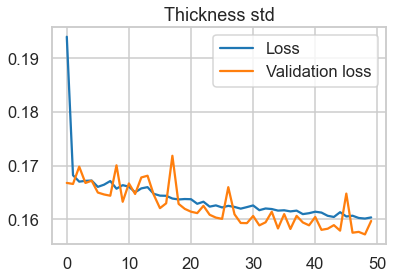

59/59 [==============================] - 0s 1ms/step - loss: 0.1597
loss: 0.1597266048192978
Depression depth
Layer added; size: 9
Layer added; size: 4
Layer added; size: 2


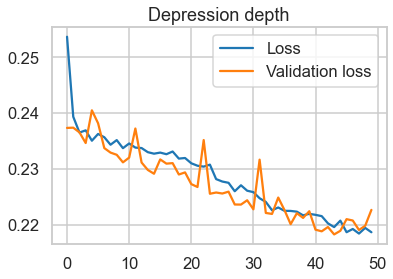

59/59 [==============================] - 0s 2ms/step - loss: 0.2226
loss: 0.22262053191661835
Depression width
Layer added; size: 9
Layer added; size: 4
Layer added; size: 2


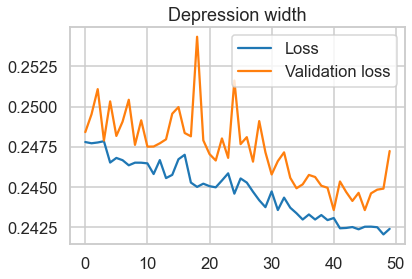

59/59 [==============================] - 0s 3ms/step - loss: 0.2472
loss: 0.2472446858882904
Pitting depth
Layer added; size: 9
Layer added; size: 4
Layer added; size: 2


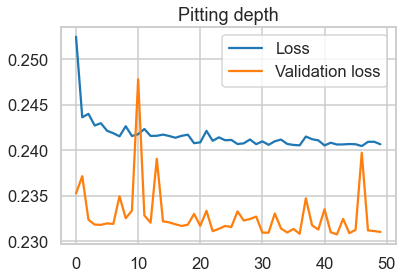

59/59 [==============================] - 0s 1ms/step - loss: 0.2310
loss: 0.23101602494716644


In [38]:
df_loss, df_test, df_predict, direct_regression_models_SPC, min_max_scalers = do_regression(SPC_norm, labels, attributes)

In [39]:
scales = np.array([[4.5, 11.0],
                   [-0.5, 11.0],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [0, 100],
                   [0, 2.25]])
df_scales = pd.DataFrame(scales.T, columns=df_test.columns)

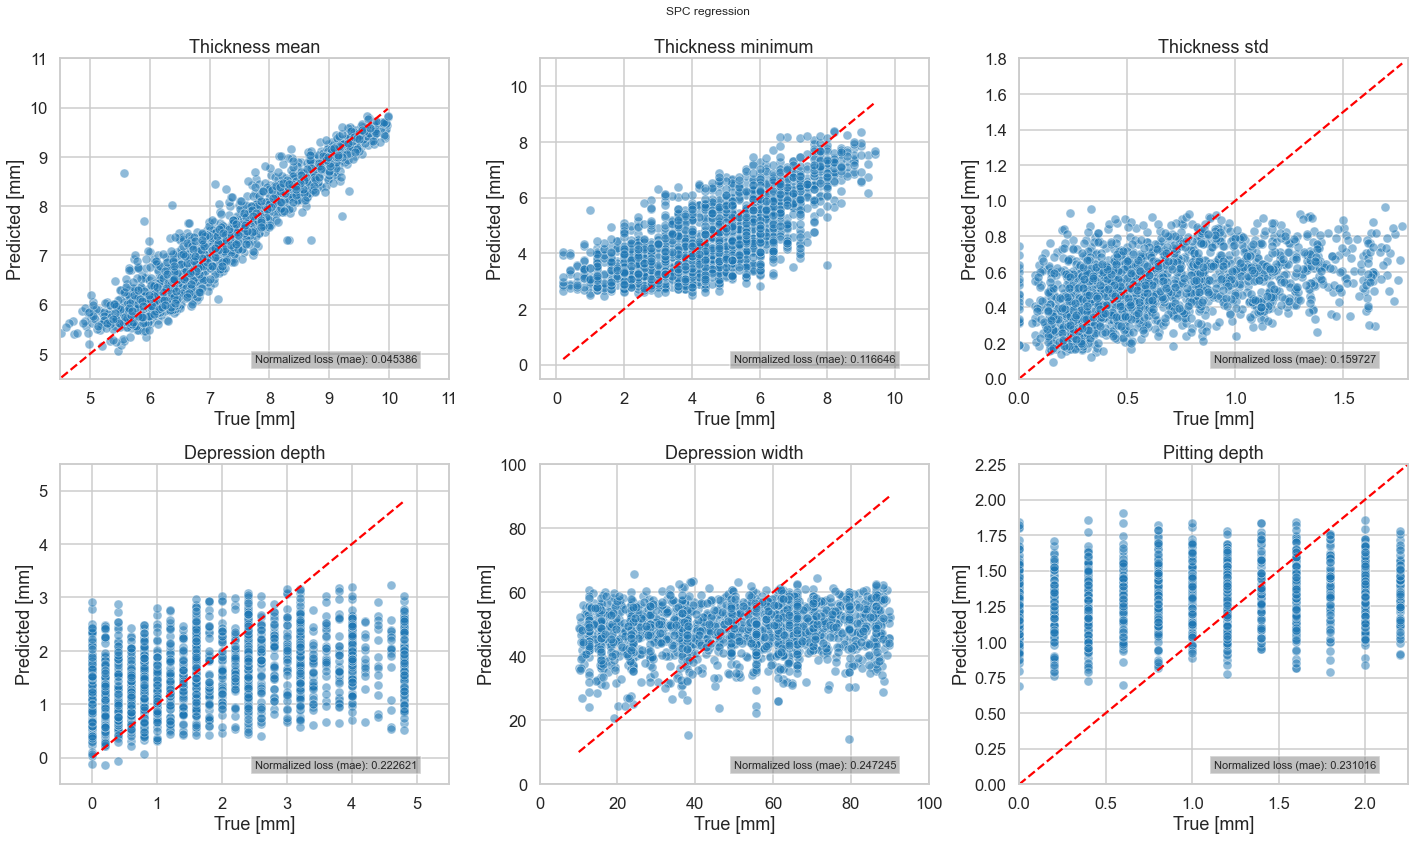

In [40]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='SPC regression')

In [41]:
len(df_test)

1877

In [101]:
df_test

,Thickness mean,Thickness minimum,Thickness std,Depression depth,Depression width,Pitting depth
0,7.569850,6.0,0.361609,0.0,23.525580,2.0
1,8.475174,5.6,0.547345,1.4,76.650678,2.6
2,8.544965,7.2,0.434854,1.4,42.273213,0.4
3,6.876852,2.4,0.985872,4.0,23.525580,1.2
4,7.070139,5.0,0.723642,2.0,84.333158,0.4
...,...,...,...,...,...,...
1872,7.599421,2.0,1.091262,3.6,40.220691,3.0
1873,6.397338,2.2,1.389468,4.2,60.292162,1.0
1874,6.128241,3.2,0.739250,3.2,23.525580,0.0
1875,5.409838,1.0,1.120387,3.0,82.628398,2.4


In [98]:
_, labels_test, _, d_estim_test  = train_test_split(labels, d_estim, test_size=0.2, random_state=42)

In [100]:
labels_test

,index,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,model_rough_coeff,num_pits
2260,2260,model_s111_t040_d000_p010,8.0,111,0.0,2.0,384.366013,23.525580,8.0,6.0,7.569850,7.6,0.361609,0.130761,1.326096,8
8663,5322,model_c3456_t048_d007_p013_r124_s1380415661,9.6,1380415661,1.4,2.6,486.148987,76.650678,9.4,5.6,8.475174,8.8,0.547345,0.299586,1.234501,6
8351,5010,model_c3456_t047_d007_p002_r197_s1697934381,9.4,1697934381,1.4,0.4,225.363130,42.273213,9.4,7.2,8.544965,8.6,0.434854,0.189098,1.291594,3
2246,2246,model_s111_t038_d020_p006,7.6,111,4.0,1.2,384.366013,23.525580,7.6,2.4,6.876852,7.2,0.985872,0.971944,1.322138,82
6074,2733,model_c3456_t039_d010_p002_r711_s1686616550,7.8,1686616550,2.0,0.4,468.462204,84.333158,7.8,5.0,7.070139,7.4,0.723642,0.523658,1.219513,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6723,3382,model_c3456_t041_d018_p015_r870_s1467483898,8.2,1467483898,3.6,3.0,224.921830,40.220691,8.2,2.0,7.599421,8.2,1.091262,1.190854,1.114373,3
5601,2260,model_c3456_t037_d021_p005_r800_s1471305838,7.4,1471305838,4.2,1.0,433.508220,60.292162,7.4,2.2,6.397338,7.2,1.389468,1.930621,1.171680,9
2111,2111,model_s111_t032_d016_p000,6.4,111,3.2,0.0,384.366013,23.525580,6.4,3.2,6.128241,6.4,0.739250,0.546490,1.003836,0
4148,807,model_c3456_t032_d015_p012_r817_s1389213886,6.4,1389213886,3.0,2.4,483.905351,82.628398,6.4,1.0,5.409838,6.0,1.120387,1.255266,1.154416,5


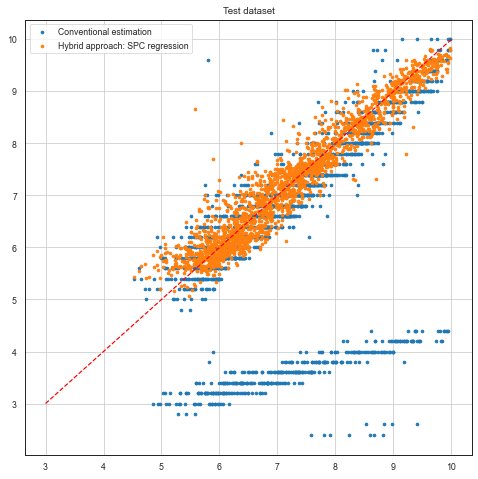

In [136]:
plt.figure(figsize=(8,8))
plt.scatter(labels_test['Thickness mean'], d_estim_test, s=8, label='Conventional estimation')
plt.scatter(df_test['Thickness mean'], df_predict['Thickness mean'], s=8, label='Hybrid approach: SPC regression')
plt.plot([3,10], [3,10], 'r--')
plt.title('Test dataset')
plt.legend()
plt.grid()
plt.show()

# Verasonics Data

In [42]:
pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_09_28', 'data')
filename_data = Path().joinpath(pathname_data, "080kHz_8ch_s1_2023-09-28_12_49_00.mat")

In [43]:
mat = scipy.io.loadmat(filename_data)
meta = mat['meta']
t_array = meta['FTaxis'][0,0]
data = mat['RFdata']

In [44]:
data = data[:,1:,:] #Remove source trace

In [45]:
np.diff(t_array).mean()/1e-6

0.8

Sample rate is 0.8 microseconds (1.25Mhz)

In [46]:
native_dt = 0.8e-6

In [47]:
data_stack = np.sum(data, axis=2)

In [48]:
def remove_dc(data):
    return data - data.mean(axis=0, keepdims=True)

In [49]:
data_stack_dc_removed = remove_dc(data_stack)

In [50]:
def compute_rms(trace):
    squared = np.float64(np.square(trace))
    mean = np.sum(squared)/len(trace)
    rms = np.sqrt(mean)
    return rms

In [51]:
def compute_rms_values(data):
    rms_values = []
    trace_nums = np.arange(0, data.shape[1])
    for trace_num in trace_nums:
        rms_values.append(compute_rms(data[:,trace_num]))
    return rms_values

In [52]:
rms_values = compute_rms_values(data_stack_dc_removed[:,:])

In [53]:
scaling_factors = [1/x for x in rms_values]

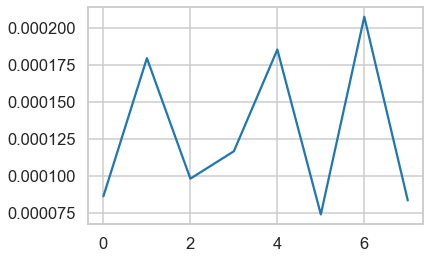

In [54]:
plt.plot(scaling_factors)

In [55]:
data_stack_scaled = np.zeros(shape=data_stack_dc_removed.shape)
for trace_num, scaling_factor in enumerate(scaling_factors):
    data_stack_scaled[:,trace_num] = scaling_factor*data_stack_dc_removed[:,trace_num]

In [56]:
data_stack_scaled[:600,:].shape

(600, 8)

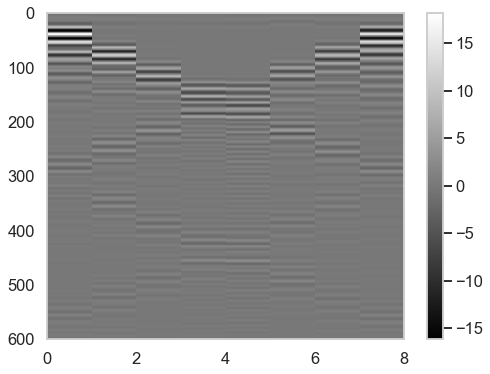

In [57]:
plt.figure(figsize=(8,6))
plt.pcolormesh(data_stack_scaled[:600,:], cmap='gray')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

In [58]:
data_stack_scaled_resamp = scipy.signal.resample(data_stack_scaled[:600,:], 480).T

In [59]:
data_stack_scaled_resamp = data_stack_scaled_resamp/data_stack_scaled_resamp.max()

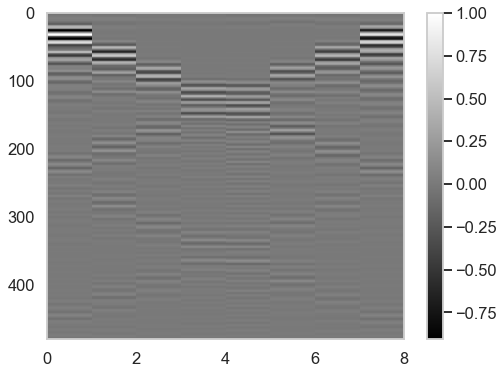

In [60]:
plt.figure(figsize=(8,6))
plt.pcolormesh(data_stack_scaled_resamp.T, cmap='gray')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

In [61]:
verasonics_data = data_stack_scaled_resamp[:,:401]

In [62]:
verasonics_data.shape

(8, 401)

In [63]:
verasonics_data = np.expand_dims(verasonics_data, axis=0)

In [64]:
verasonics_data.shape

(1, 8, 401)

In [65]:
#ds = np.arange(5, 10.0, 0.05)
len(ds)

39

In [66]:
fk, k_array, f_array = make_multiple_fk(verasonics_data, dt, make_dtheta(1))

#fk = np.abs(fk_c)
#fk = 20*np.log10(np.abs(fk_c)/np.max(np.abs(fk_c)))


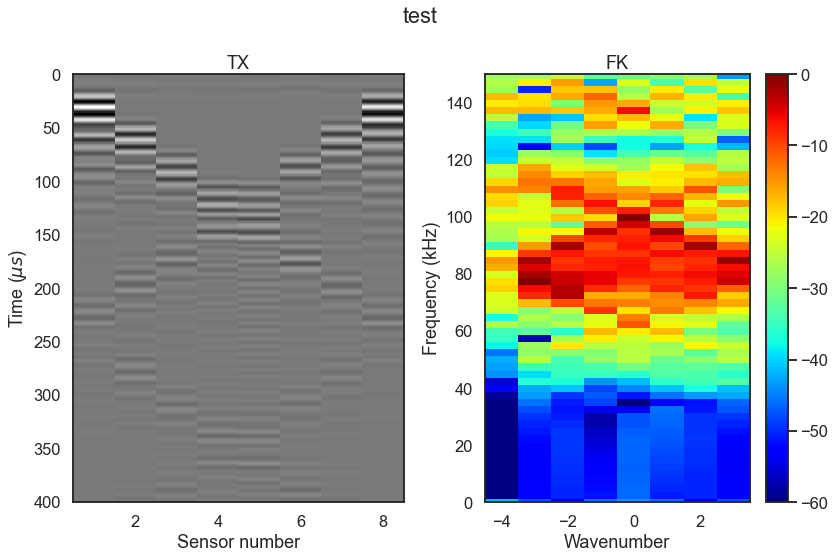

In [67]:
tx_fk_plot(verasonics_data[0,:,:].T, dt, dx=make_dtheta(1), title='test')

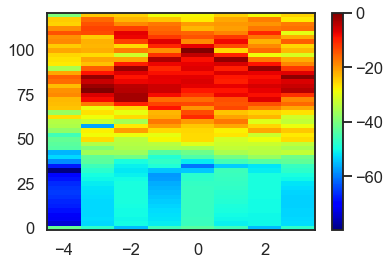

In [68]:
plt.figure()
plt.pcolormesh(k_array, f_array/1e3, fk[0,:,:].T, cmap='jet')
plt.colorbar()
#plt.clim(-60, 0)
plt.show()

In [69]:

d_estim_temp, SPC_verasonics = FK_thickness_estimation(fk.T, k_array, f_array, make_dtheta(1), steel.vp_antisym['A0'], ds, 40e3, 120e3, angular=True, circumference=circ, db=True, plot=False, return_power_curve=True, circ_correction=True)

In [70]:
f_array.shape, k_array.shape, fk.shape

((49,), (8,), (1, 8, 49))

In [71]:
d_estim_temp

6.8

In [72]:
SPC_v = np.array(list(SPC_verasonics.values()))
SPC_v = (SPC_v-SPC.min())/((SPC-SPC.min()).max())

In [73]:
labels[labels['Thickness'] == 6.8]

,index,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,model_rough_coeff,num_pits
42,42,model_s101_t034_d000_p000,6.8,101,0.0,0.0,351.267366,55.653407,6.8,6.8,6.800000,6.8,0.000000,0.000000,1.000000,0
43,43,model_s101_t034_d000_p002,6.8,101,0.0,0.4,351.267366,55.653407,6.8,6.4,6.603877,6.6,0.145226,0.021091,1.271427,0
44,44,model_s101_t034_d000_p004,6.8,101,0.0,0.8,351.267366,55.653407,6.8,6.0,6.469792,6.4,0.234485,0.054983,1.314587,228
45,45,model_s101_t034_d000_p006,6.8,101,0.0,1.2,351.267366,55.653407,6.8,5.6,6.414352,6.4,0.289402,0.083753,1.322979,85
46,46,model_s101_t034_d000_p008,6.8,101,0.0,1.6,351.267366,55.653407,6.8,5.2,6.399595,6.4,0.310864,0.096637,1.324897,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4730,1389,model_c3456_t034_d023_p001_r070_s1720746496,6.8,1720746496,4.6,0.2,452.471917,62.164359,6.4,1.4,5.017593,6.0,1.525157,2.326104,1.165206,8
4731,1390,model_c3456_t034_d023_p007_r627_s1727734027,6.8,1727734027,4.6,1.4,338.514252,83.420493,6.8,1.0,5.202199,6.0,1.637589,2.681697,1.277539,5
4732,1391,model_c3456_t034_d023_p009_r960_s1612860553,6.8,1612860553,4.6,1.8,438.610731,64.923237,6.8,0.8,5.670312,6.6,1.571158,2.468537,1.055746,9
4733,1392,model_c3456_t034_d023_p013_r881_s1617975390,6.8,1617975390,4.6,2.6,270.568774,16.411050,6.8,0.2,6.401620,6.8,1.025768,1.052200,1.126960,10


In [74]:
SPC_v.shape

(39,)

In [75]:
SPC_v = np.expand_dims(SPC_v, axis=0)

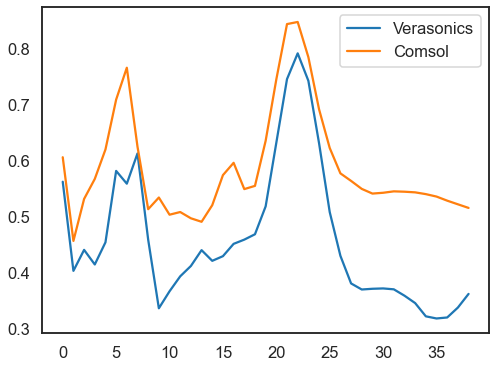

In [94]:
plt.figure(figsize=(8, 6))
plt.plot(SPC_v[0,:], label='Verasonics')
plt.plot(SPC_norm[42,:], label='Comsol')
plt.legend()
plt.show()

In [87]:
real_prediction_SPD_regression = {}
for i, attribute in enumerate(attributes):
    real_prediction_SPD_regression_norm = direct_regression_models_SPC[attribute](SPC_v)
    real_prediction_SPD_regression[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_SPD_regression_norm)

In [88]:
real_prediction_SPD_regression

{'Thickness mean': array([[7.05097419]]),
 'Thickness minimum': array([[5.26241444]]),
 'Thickness std': array([[0.35607415]]),
 'Depression depth': array([[0.50164136]]),
 'Depression width': array([[30.88614049]]),
 'Pitting depth': array([[0.98621941]])}